In [1]:
import pandas as pd
import numpy as np

In [2]:
interval = 11
xlim = 1500
social_deployment = [
    "compose-post-service",
#     "home-timeline-service",
    "nginx-thrift",
    "post-storage-service",
#     "social-graph-service",
#     "text-service",
#     "unique-id-service",
#     "url-shorten-service",
#     "user-mention-service",
#     "user-service",
    "user-timeline-service"
]

root_path = "./data/235/cus2"
usage_data = dict()
npod_data = dict()
temp_data = dict()
for sd in social_deployment:
    usage_data[sd] = []
    npod_data[sd] = []
    temp_data[sd] = [0, 0]

# f = open(root_path + "/horizontalpodautoscalers.log", 'r')
# lines = f.readlines()
# for line in lines:
#     for sd in social_deployment:
#         if line.find(sd) != -1:
#             usage_data[sd].append(int(line.split("%/")[0].split(" ").pop()))
#             for _i in (line.strip().split("20 ")[1]):
#                 if _i != " ":
#                     npod_data[sd].append(int(_i))
#                     break
# f.close()

f = open(root_path + "/top.log", 'r')
lines = f.readlines()
for i, line in enumerate(lines):
    if line.find("[#") != -1 or i < 3: 
        continue
    if line.find("NAME") != -1:
        for sd in social_deployment:
            npod_data[sd].append(temp_data[sd][0])
            usage_data[sd].append(temp_data[sd][1]/float(temp_data[sd][0]))
            temp_data[sd] = [0, 0]
        continue
        
    for sd in social_deployment:
        if line.find(sd) != -1:
            temp_data[sd][0] += 1
            if line.split("m      ")[0].split(" ").pop().isnumeric():
                temp_data[sd][1] += int(line.split("m      ")[0].split(" ").pop())
            else:
                temp_data[sd][1] += int(line.split("m      ")[1].split("m      ")[0].split(" ").pop())
            
            
f.close()

df_usage = pd.DataFrame(usage_data)
df_npod = pd.DataFrame(npod_data)
apis = {
    "compose": [],
    "user-timeline": [],
    "home-timeline": []
}
key = ""
f = open(root_path + "/output.log", 'r')
lines = f.readlines()
for line in lines:
    if key != "":
        if line.find("Latency ") != -1:
            apis[key].append(line.strip().split("Latency ")[1].split("s ")[0] + "s")
            key = ""
        continue
    if line.find("Test Result") != -1:
        for api in apis:
            if line.find(api) != -1:
                key = api
#display(pd.DataFrame(apis))
print(apis)
f.close()


# requests success rate
total_requests = 0.0
total_fail_requests = 0.0
f = open(root_path + "/output.log", 'r')
lines = f.readlines()

for line in lines:
    if line.find("Sent ") != -1:
        total_requests += int(line.strip().split(" ")[1])
    if line.find("Non-2xx or 3xx responses:") != -1:
        total_fail_requests += int(line.strip().split(": ")[1])

f.close()

print(total_requests)
print(total_fail_requests)
print(((total_requests-total_fail_requests)/total_requests)*100)




{'compose': ['  947.45ms', '   18.11s', '   30.59s', '   26.11s', '   31.87s', '   26.36s', '   26.96s', '   23.52s', '   26.22s', '   26.30s', '   28.96s', '   30.27s'], 'user-timeline': ['  509.41ms', '    8.73s', '    4.92s', '  942.40ms', '    1.31s', '    1.34s', '    3.03s', '  688.82ms', '  615.72ms', '  441.99ms', '  593.05ms', '  532.28ms'], 'home-timeline': ['  654.69ms', '    3.85s', '    2.47s', '  925.96ms', '    1.09s', '    1.24s', '    2.91s', '    3.56s', '    6.51s', '   10.66s', '   16.44s']}
1594264.0
285423.0
82.09687981413367


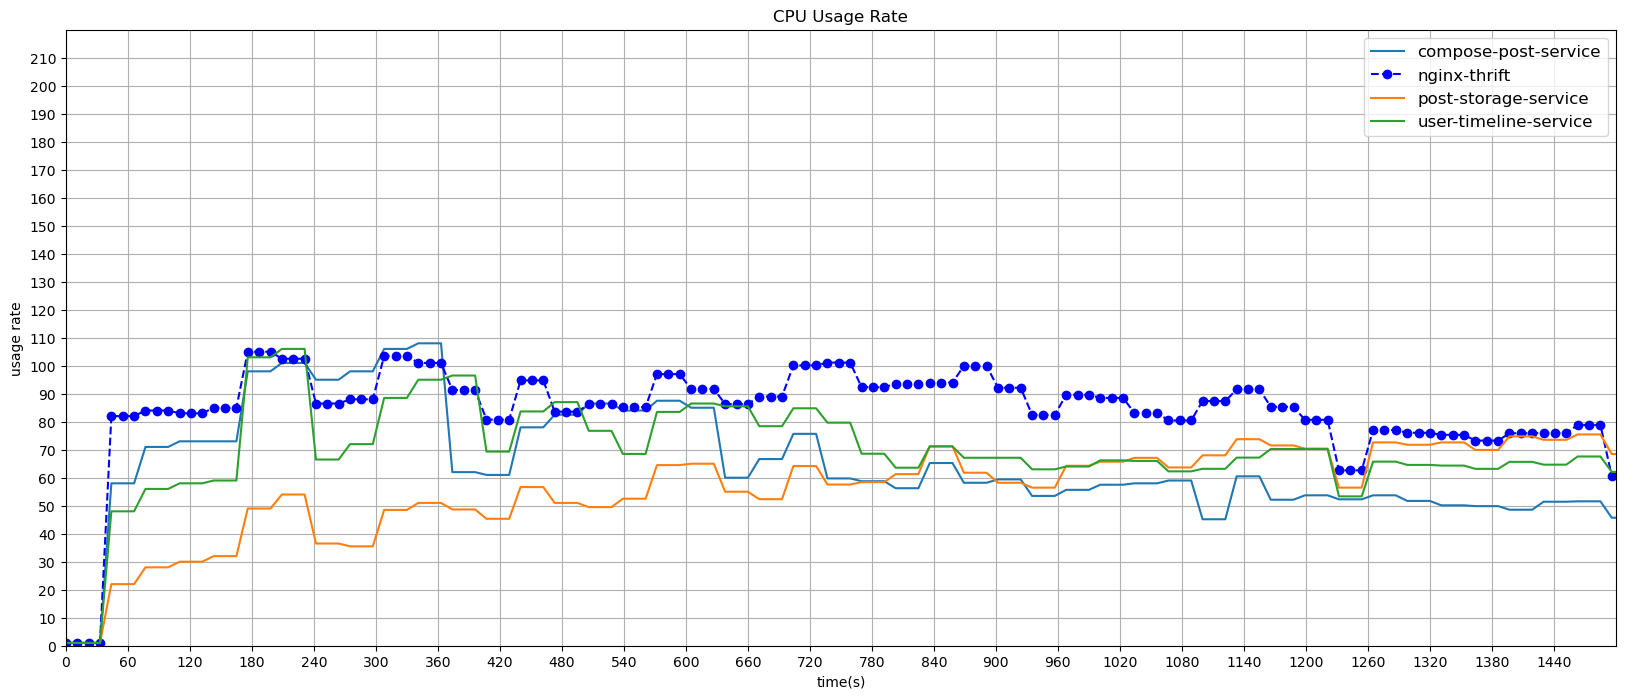

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
for sd in social_deployment:
    if sd == "nginx-thrift":
        plt.plot(df_usage.index * interval , df_usage[sd], 'ob--')
    else:
        plt.plot(df_usage.index * interval , df_usage[sd])
    plt.yticks(np.arange(0,220,10))
    plt.xticks(np.arange(0,xlim,60))
    
plt.xlabel('time(s)')
plt.ylabel('usage rate')
plt.title('CPU Usage Rate')
plt.legend(social_deployment, fontsize=12, loc='best')
plt.grid()  # 그리드
plt.ylim(0, 220)
plt.xlim(0, xlim)
plt.show()


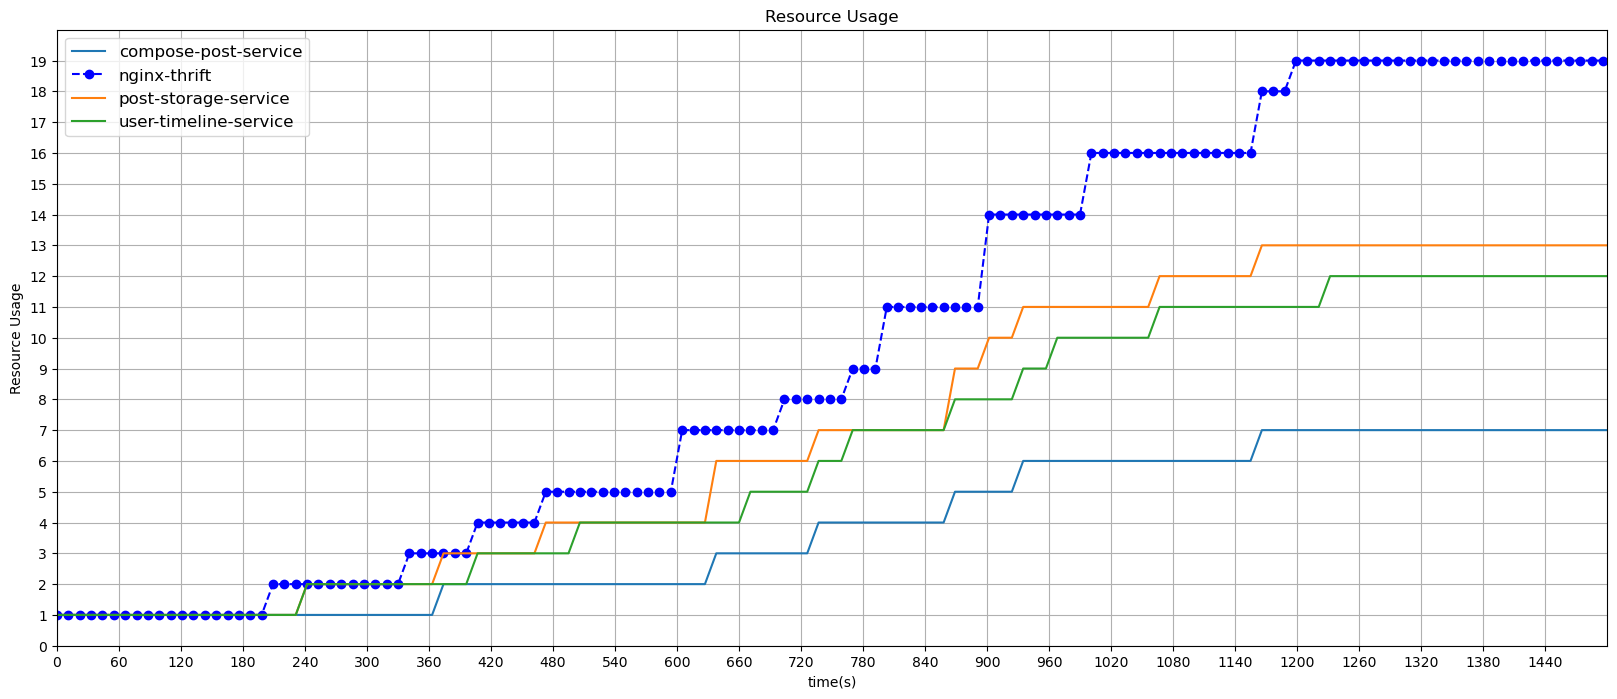

In [4]:
plt.figure(figsize=(20,8))
for sd in social_deployment:
    if sd == "nginx-thrift":
        plt.plot(df_npod.index * 11, df_npod[sd], 'ob--')
    else:
        plt.plot(df_npod.index * 11, df_npod[sd])
    plt.yticks(np.arange(0,20,1))
    plt.xticks(np.arange(0,xlim,60))
    
plt.xlabel('time(s)')
plt.ylabel('Resource Usage')
plt.title('Resource Usage')
plt.legend(social_deployment, fontsize=12, loc='best')
plt.grid()  # 그리드
plt.ylim(0, 20)
plt.xlim(0, xlim)
plt.show()

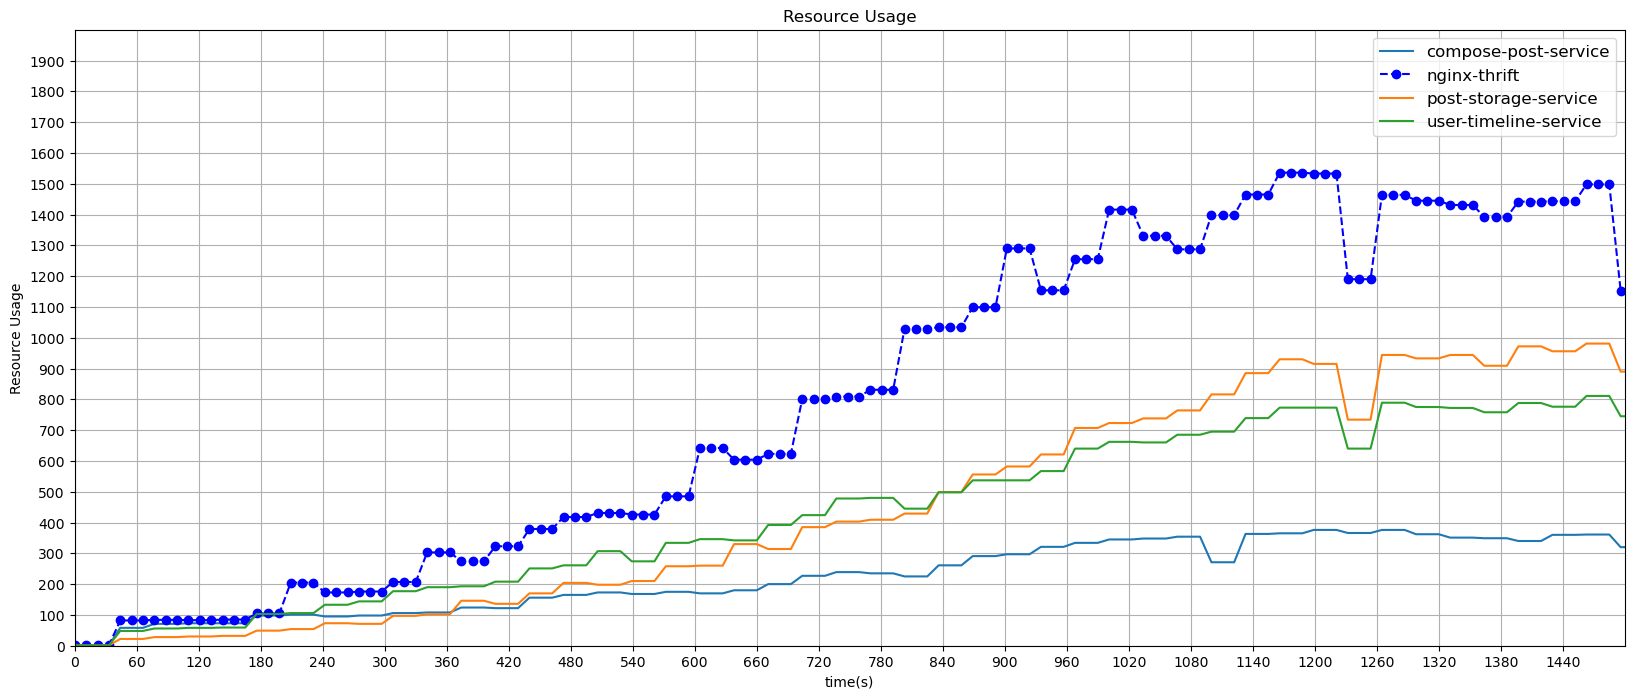

In [5]:
plt.figure(figsize=(20,8))
for sd in social_deployment:
    if sd == "nginx-thrift":
        plt.plot(df_npod.index * interval, df_usage[sd]*df_npod[sd], 'ob--')
    else:
        plt.plot(df_npod.index * interval, df_usage[sd]*df_npod[sd])
    plt.yticks(np.arange(0,2000,100))
    plt.xticks(np.arange(0,xlim,60))
    
plt.xlabel('time(s)')
plt.ylabel('Resource Usage')
plt.title('Resource Usage')
plt.legend(social_deployment, fontsize=12, loc='best')
plt.grid()  # 그리드
plt.ylim(0, 2000)
plt.xlim(0, xlim)
plt.show()